# Chapter 26 - Classifiers

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("Chapter26").getOrCreate()

In [5]:
bInput = spark.read.format("parquet").load("../data/binary-classification")\
                                    .selectExpr("features", "cast(label as double) as label")
bInput.show(5)

+--------------+-----+
|      features|label|
+--------------+-----+
|[3.0,10.1,3.0]|  1.0|
|[1.0,0.1,-1.0]|  0.0|
|[1.0,0.1,-1.0]|  0.0|
| [2.0,1.1,1.0]|  1.0|
| [2.0,1.1,1.0]|  1.0|
+--------------+-----+



## Logistic Regression

In [3]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
print(lr.explainParams())
lrModel = lr.fit(bInput)  # , fits the model with default params, returns a Model
print(type(lrModel))

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [4]:
print(lrModel.coefficients)
print(lrModel.intercept)

[6.848741326854929,0.3535658901019745,14.814900276915923]
-10.22569586448109


In [13]:
summary = lrModel.summary
print(summary.areaUnderROC)
summary.roc.show()
summary.pr.show()

1.0
+---+------------------+
|FPR|               TPR|
+---+------------------+
|0.0|               0.0|
|0.0|0.3333333333333333|
|0.0|               1.0|
|1.0|               1.0|
|1.0|               1.0|
+---+------------------+

+------------------+---------+
|            recall|precision|
+------------------+---------+
|               0.0|      1.0|
|0.3333333333333333|      1.0|
|               1.0|      1.0|
|               1.0|      0.6|
+------------------+---------+



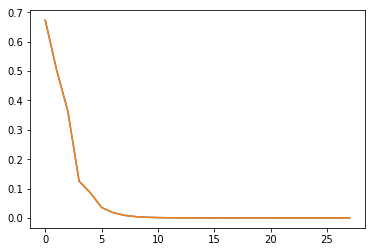

In [11]:
import matplotlib.pyplot as plt

plt.plot(summary.objectiveHistory)
plt.show()

## Decision Trees

In [19]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
print(dt.explainParams())
dtMpdel = dt.fit(bInput)  # fits data and returns model

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree.

## Random Forests
Each tree becomes expert in one area and then we achieve prediction by wisdom of the crowds

In [25]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier()
print(rf.explainParams())
model = rf.fit(bInput)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
maxBins: Max

## Gradient Boosted Trees


In [21]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier()
print(gbt.explainParams())
gbt.fit(bInput)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0)

GBTClassificationModel (uid=GBTClassifier_4025a3abf9cc2a542d8b) with 20 trees

## Naive Bayes

Shoudl work under the assumption that all features are uncorrelated, but this is hardly true. Maakt niet uit.

In [22]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes()
print(nb.explainParams())
trainedModel = nb.fit(bInput.where("label!=0"))

featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
modelType: The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli. (default: multinomial)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is 

## Evaluation metrics

Some metrics are only available at RDD level

In [33]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

out = model.transform(bInput).select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = BinaryClassificationMetrics(out)

print(metrics.areaUnderROC)
print(metrics.areaUnderPR)
print("Receiver Operating Characteristic")
# NOTE: on the book the following line is to be executed, does not work with newer versions of spark.
#metrics.roc.toDF().show()

1.0
1.0
Receiver Operating Characteristic


[(1.0, 1.0), (0.0, 0.0)]